# Recommending Offer


As we have seen in our data exploration and analysis, spend varies by demographic. On the other hand the plots show that by sending offers, we can influence the number purchases. However, it's difficult to tell which one has a higher influence. In this section, we'll defer to ML to assist with this. 

We will look into building a recommender that returns the offer that has the highest level of influence. Keep in mind that offers that have a high level of influence are offers that have a high level of user response. Given each user profile as input, the recommender will return an offer that would get the best response.

We are going to train two models that learn the demographic data and their corresponding response to the offers. The first one serves as a benchmark model that provides a reference to show how well the second model performs relative to it. 

Our criteria is to select an alogrithm that works well with multidemnsional data and arbitrary inputs such as time, categorial and numerical data. 

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelBinarizer

%matplotlib inline

# Defining the ML Problem

We were given a list of users and their demographics and transcript data. We have cleaned and joined the data into a single dataframe that contains whether or not a user received an offer and whether or not they responded to it.

There are ten offers in the portfolio. The goal is to predict which offer would most likely get a response. If a user return to the app at a later date, we'd want to know which offer to send this user. This problem can be framed as a ranking problem. For each demographic group, we will predict which offer will get the highest response and recommend that one. 

To account for the negative case, for users who do not need an offer but would purchase on the app anyway, we define 'no_offer'. All together, there are 11 possible outcomes: ten offers from the portfolio and 'no_offer'.

We need the ability to rank the offers and pick one with the best rank. Using machine learning, we should be able assign a probability of response to each offer in order to rank them and pick one with the best rank.



We will use a `DecisionTreeClassifier` as our benchmark model.

We will use `RandomForestClassifier` as our final model.

# Evaluation Metric
To guage the performance of our models, we defer to NDCG (normalized discounted cumulative gain) @k. 
NDCG is defined as:

$$ DCG_{k} = \sum_{i=1}^k \frac{2^{rel_{i}} - 1}{log_{2}(i + 1)}$$

$$ {n}DCG_{k} = \frac{DCG_{k}}{IDCG_{k}} $$

$rel_{{i}}$ is the relevance of the result at position $i$

${IDCG_{k}}$ is the Ideal DCG (IDCG) through position ${k}$. It produces the maximum possible DCG.

${n}DCG_{k}$ is the normalized DCG at position ${k}$ calculated by the DCG value at rank ${k}$ by the ideal ranking.

All normalized DCG (NDCG) values on the interval 0.0 to 1.0, where higher is better.

More information about NDCG can be found at https://en.wikipedia.org/wiki/Discounted_cumulative_gain.

The number of outcomes for our dataset is small, and a user don't receive very many offers, we should limit our evaluation to only the top 3 offers and thus consider k=3.

In other words, our models are graded based on whether or not they get the top 3 offers right for each demographic group. It doesn't matter what order the top 3 items are in as long as they are in the top 3.


In [3]:
def calculate_dcg(y, k):
    """Calculate DCG at k"""
    rel = np.take(y, np.arange(k))
    gains = 2 ** rel - 1
    # i starts at 1 while range/index starts at 0, so plus 1
    discounts = np.log2((np.arange(len(rel)) + 1) + 1)
    return np.sum(gains/discounts)

def calculate_ndcg(y_true, y_pred, k):
    """Calculate nDCG at k"""
    ranked_indices = np.argsort(y_pred)[::-1]
    rel = np.take(y_true, ranked_indices)
    dcg = calculate_dcg(rel, k)

    ranked_indices = np.argsort(y_true)[::-1]
    rel = np.take(y_true, ranked_indices)
    idcg = calculate_dcg(rel, k)
    return dcg/idcg

def evaluate(y_true, y_pred):
    """Evaluate y_true against y_pred using ndcg@3"""
    k=3
    lb = LabelBinarizer()
    lb.fit(range(y_pred.shape[1] + 1))
    binarized_labels = lb.transform(y_true)

    scores = []
    for y_true, y_pred in zip(binarized_labels, y_pred):
        scores.append(calculate_ndcg(y_true, y_pred, k))
        
    return np.mean(scores)

# Make scoring function to use with grid search
ndcg_scoring = make_scorer(evaluate, needs_proba=True)


# Features and labels

In [23]:
transactions = pd.read_csv('data/clean/transactions.csv', index_col=0)
profile = pd.read_csv('data/clean/profile.csv', index_col=0)
portfolio = pd.read_csv('data/clean/portfolio.csv', index_col=0)

In [24]:
transactions.columns

Index(['person', 'time', 'amount', 'offer_id', 'receive_time', 'view_time',
       'complete_time', 'time_expire', 'channels', 'difficulty', 'duration',
       'offer_type', 'reward', 'validity', 'influenced_by_bogo',
       'influenced_by_discount', 'influenced_by_info', 'age_x',
       'became_member_on_x', 'gender_x', 'income_x', 'avg_income_x',
       'age_bracket_x', 'income_bracket_x', 'age_y', 'became_member_on_y',
       'gender_y', 'income_y', 'avg_income_y', 'age_bracket_y',
       'income_bracket_y', 'age', 'became_member_on', 'gender', 'income',
       'avg_income', 'age_bracket', 'income_bracket'],
      dtype='object')

In [25]:
ml_data = transactions[[
    'offer_id', 'became_member_on', 'age', 'gender', 'income', 'influenced_by_info',
       'influenced_by_bogo', 'influenced_by_discount',
]]

In [26]:
# ml_data['became_member_year_mon'] = ml_data['became_member_on'].apply(lambda x: round(x/100))
# ml_data['became_member_year'] = ml_data['became_member_on'].apply(lambda x: round(x/10000))
# ml_data = ml_data.merge(portfolio[['offer_id', 'difficulty', 'reward', 'offer_type']], on='offer_id', how='left')
# ml_data['difficulty'].fillna(0, inplace=True)
# ml_data['reward'].fillna(0, inplace=True)
# ml_data['offer_type'].fillna('no_an_offer', inplace=True)

In [27]:
ml_data = ml_data[ml_data['offer_id'].notnull()]

In [28]:
# Make sure there are no null values.
ml_data['influenced_by_info'].fillna(False, inplace=True)
ml_data['influenced_by_bogo'].fillna(False, inplace=True)
ml_data['influenced_by_discount'].fillna(False, inplace=True)

In [29]:
def get_influenced_offer(row):
    """Get the offer_id that influenced the transaction"""
    if row['influenced_by_info'] or row['influenced_by_bogo'] or row['influenced_by_discount']:
        return row['offer_id']
    else:
        return 'no_offer'
ml_data['offer_id'] = ml_data.apply(get_influenced_offer,axis=1)

In [30]:
ml_data.isna().sum()

offer_id                  0
became_member_on          0
age                       0
gender                    0
income                    0
influenced_by_info        0
influenced_by_bogo        0
influenced_by_discount    0
dtype: int64

In [31]:
# Convert gender to numeric
dummies = pd.get_dummies(ml_data['gender'], drop_first=True, prefix='gender')
ml_data = pd.concat([ml_data, dummies], axis=1)


In [32]:
# Get numeric representation of the labels
offer_labels, offer_definitions = pd.factorize(ml_data['offer_id'])
ml_data['offer_label'] = offer_labels



In [33]:
# Save factorized labels and offers so that we can use for in the webapp.
offers_to_save = ml_data[['offer_label', 'offer_id']].merge(portfolio, on='offer_id', how='left').drop_duplicates()
offers_to_save.to_json('data/app/offers.json', orient='records', lines=True)

In [34]:
ml_data[['gender', 'became_member_on', 'age', 'income']].drop_duplicates().to_json('data/app/demographics.json', orient='records', lines=True)
# ml_data[['age']].drop_duplicates().to_json('data/app/age.json', orient='records', lines=True)


In [35]:
ml_data.columns

Index(['offer_id', 'became_member_on', 'age', 'gender', 'income',
       'influenced_by_info', 'influenced_by_bogo', 'influenced_by_discount',
       'gender_M', 'gender_O', 'gender_U', 'offer_label'],
      dtype='object')

In [36]:
ml_data = ml_data[['age', 'income', 'became_member_on',
                   'gender_M', 'gender_O', 'gender_U', 
                   'offer_label']]

In [37]:
X = ml_data.drop('offer_label', axis=1)
y = ml_data[['offer_label']]


Perform 80/20 train-test split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
X.to_csv('data/clean/X.csv')
y.to_csv('data/clean/y.csv')
X_train.to_csv('data/clean/X_train.csv')
y_train.to_csv('data/clean/y_train.csv')
X_test.to_csv('data/clean/X_test.csv')
y_test.to_csv('data/clean/y_test.csv')



# Decision Tree

In [22]:
dt = DecisionTreeClassifier(max_depth=12, random_state=42)

In [23]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [24]:
dt.feature_importances_

array([0.27749957, 0.26493078, 0.40514893, 0.04473878, 0.00768194,
       0.        ])

In [25]:
X.columns

Index(['age', 'income', 'became_member_on', 'gender_M', 'gender_O',
       'gender_U'],
      dtype='object')

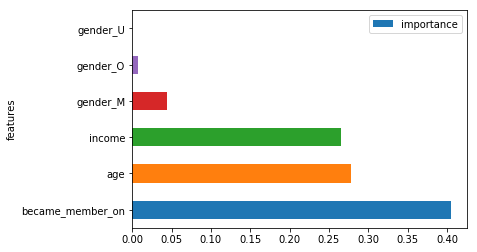

In [26]:
pd.DataFrame({'features': X.columns, 'importance': dt.feature_importances_}).sort_values('importance', ascending=False).plot.barh(x='features', y='importance')

In [29]:
y_pred = dt.predict_proba(X_test)
print('nDCG@3: {}'.format(evaluate(y_test, y_pred)))


nDCG@3: 0.588288652671588


Our baseline nDCG@3 is 0.59

# Random Forest

In [30]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [31]:
y_pred = rf.predict_proba(X_test)
print('nDCG@3: {}'.format(evaluate(y_test, y_pred)))


nDCG@3: 0.6237672426784215


Slightly better than decision tree. Need to tune hyperparameters.

Before we tune hyperparameters, let's do a sniff test to make sure we constructed the correct ML model. We need to make sure that it's actually recommending the best offer.

In [32]:
ml_data.shape

(86225, 7)

In [33]:
ml_data[86000:].head(1)

,age,income,became_member_on,gender_M,gender_O,gender_U,offer_label
151240,65,59000.0,20131207,0,0,0,9


Let's try recommending offer for demographic group where age=118, income=67800 and became_member_on=20160219

In [34]:
tmp_X = ml_data[
    (ml_data['age']==65) &
    (ml_data['income']==59000.0) &
    (ml_data['became_member_on']==20131207) &
    (ml_data['gender_M']==0) &
    (ml_data['gender_O']==0) &
    (ml_data['gender_U']==0)
]

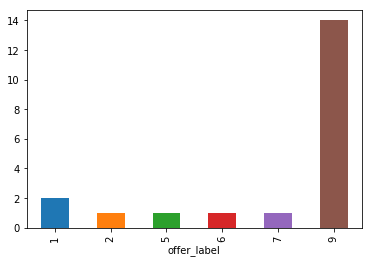

In [37]:
tmp_X.groupby(['offer_label'])['offer_label'].count().plot.bar()

In [38]:
tmp_X.groupby(['offer_label'])['offer_label'].count()

offer_label
1     2
2     1
5     1
6     1
7     1
9    14
Name: offer_label, dtype: int64

Base on this plot, offer with label 9 should be returned, since it has the highest bar relative to all the other ones.
For nDCG@3, we're looking for releavant top 3 items. That's either 9, 1 or any of [2,5,6,7] since they're equal. But because 9 far beats all others, as long as we get 9, we can say that our ML model is working.

In [36]:
rf.predict(tmp_X.drop('offer_label', axis=1))

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

👍

# Tuning Hyperparameters

## Random search

Since we don't know where to start, use `RandomSearchCV` to randomly sample from the grid to narrow down the search. 

In [2314]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 20)]
max_depth.append(None)
grid = {'n_estimators': n_estimators,
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 4, 8],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}


In [2315]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier(n_estimators=1000, max_depth=12, random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=grid, n_iter=80, cv=2, verbose=10, random_state=42, n_jobs=-1, scoring=ndcg_scoring)


In [2316]:
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 80 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  6.0min
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Don

RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=80, n_jobs=-1,
          param_distributions={'n_estimators': [200, 218, 236, 254, 272, 290, 309, 327, 345, 363, 381, 400, 418, 436, 454, 472, 490, 509, 527, 545, 563, 581, 600, 618, 636, 654, 672, 690, 709, 727, 745, 763, 781, 800, 818, 836, 854, 872, 890, 909, 927, 945, 963, 981, 1000, 1018, 1036, 1054, 1072, 1090, 1109, ...0, None], 'min_samples_split': [2, 4, 8], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', ra

In [2317]:
best_rf = random_search.best_estimator_
print('Best model from random search, nDCG@3: {}'.format(evaluate(y_test, best_rf.predict_proba(X_test))))

Best model from random search, nDCG@3: 0.6813996584906634


In [2320]:
random_search.best_params_

{'n_estimators': 1836,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

## Grid Search

From random search, we have an idea of where the best params are. We'll use it as guidance for picking hyperparameters.

Create a new grid based on the best params from random search.

In [2420]:
grid = {'n_estimators': [1800, 2000, 2200],
               'max_features': ['auto'],
               'max_depth': [20, 25, 30],
               'min_samples_split': [8, 10, 12],
               'min_samples_leaf': [1, 5, 10],
               'bootstrap': [True]}

In [ ]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(n_estimators=1000, max_depth=12, random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=grid, cv = 3, verbose=10, n_jobs=-1, scoring=ndcg_scoring)


In [ ]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [2327]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 25,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 2000}

In [2328]:
best_rf = grid_search.best_estimator_

In [2329]:
evaluate(y_test, best_rf.predict_proba(X_test))

0.6826561898997674

Better than our benchmark `DecisionTreeClassifier` of 0.59 and our initial `RandomForestClassifier` of 0.62.
Going from 0.59 to 0.68 is a 15% improvement.

Save the model for webapp

In [2331]:
import pickle
import bz2
with bz2.BZ2File('models/rf.pkl.bz2', 'w') as file:
    pickle.dump(best_rf, file)

# Reflection
We only train DecisionTree and RandomForest here. It's expected that RandomForest, which is an ensemble of many decision trees, to perform better than a single decision. However, nDCG@3 score of 0.68 feels like there is room for improvement. We haven't exhausted the learning. We can further explore other algorithms, for example, XGBoost and multi-layer perceptron neural networks. As a future |, we should train multiple models, stack their learning and combine their predictions.